# Seas the Data

In [ ]:
%matplotlib widget
# Included widget so I could manually zoom in on the data
import sys
from pathlib import Path
from typing import Optional
import logging

import matplotlib.pyplot as plt
import pandas as pd

from Model import RedemptionModel
from AFTER_Analysis import AnalysisEngine, set_logging
from Context import Context

In [2]:
def run(
    path_in: Path,
    split_date: Optional[pd.Timestamp]=None,
    split_fraction: Optional[float]=None,
    split_test_timedelta: Optional[pd.Timedelta]=None,
    plot: bool=True,
    debug: bool=False,
    verbose: bool=True
) -> AnalysisEngine:
    ctx = Context(
        path_in=path_in,
        split_date=split_date,
        split_fraction=split_fraction,
        split_test_timedelta=split_test_timedelta,
        plot=plot,
        debug=debug,
        verbose=verbose
    )
    set_logging(ctx)
    logging.info(
        f"Starting analysis with:\n"
        f"\tContext : {ctx}"
    )
    logging.info("Constructing analysis engine.")
    ae = AnalysisEngine(ctx)
    ae.read_csv(path_in)

    ae.prepare_for_projection()
    if ae.ctx.plot:
        ae.profile_sub_day.reset_index().plot(
            x="Time_of_day",
            y=["Redemption Count_mean", "Sales Count_mean"],
            figsize=(14,5),
            title="Sub-day profile"
        )
        ae.profile_weekly.reset_index().plot(
            x="Day_of_week",
            y=["Redemption Count", "Sales Count"],
            kind="line",
            marker="o",
            figsize=(14, 5),
            title="Weekly profile"
        )
        ae.profile_annual.plot(
            figsize=(12, 5),
            title="Annual profile"
        )
        # Rolling trend only used during dev for insights
        # ae.trend_rolling.plot(
        #     figsize=(14, 5),
        #     title="30-day rolling average"
        # )
        # Plot Take2 and Take3 - yearly summations and rolling average
        ax = ae.df_yearly.plot(
            kind="line",
            marker="o",
            figsize=(12, 5),
            title="Overall trend"
        )
        ae.df_yearly_rolling.plot(
            kind="line",
            marker="x",
            linestyle="--",
            ax=ax,
            label=["Redemption Trend", "Sales Trend"]
        )

        plt.xlabel("Year")
        plt.ylabel("Total Count")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return ae


INFO: Starting analysis with:
	Context : Context(path_in=WindowsPath('data/Toronto Island Ferry Ticket Counts.csv'), split_date=None, split_fraction=None, split_test_timedelta=None, plot=True, verbose=True, debug=False)
INFO: Constructing analysis engine.
INFO: Reading data from data\Toronto Island Ferry Ticket Counts.csv
INFO: No time split specified, using full data for training
INFO: Using full data set for training
INFO: Component 1 - sub-day profile
INFO: Component 2 - weekly profile
INFO: Component 3 - annual profile
INFO: Component 4 - overall trend


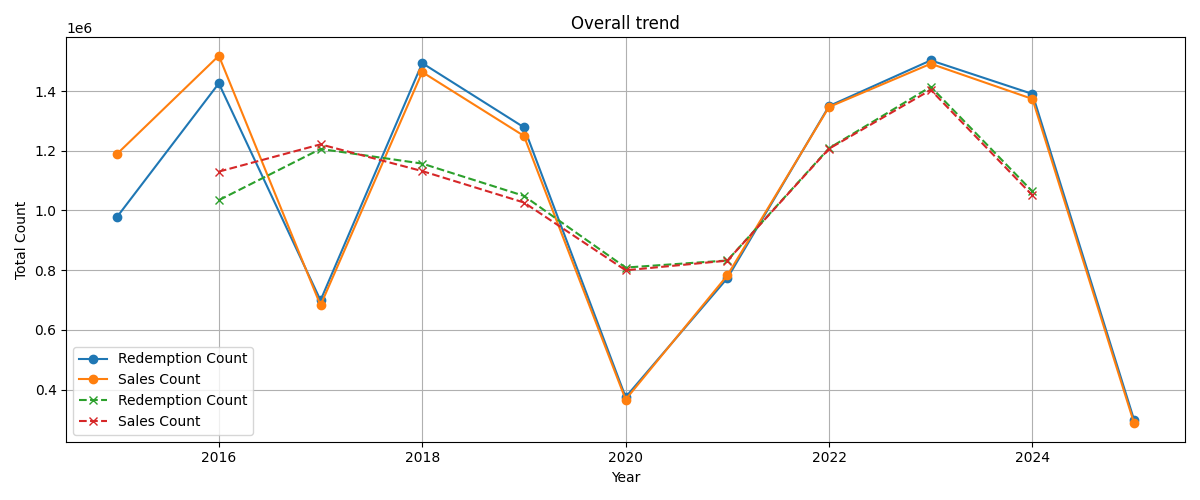

INFO: Evaluating uncertainty using test set
INFO: Extrapolating to year 2015
INFO: Extrapolating to year 2025
INFO: Uncertainty Evaluation Complete:
	MAE  :	Redemption Count    27.885341
Sales Count         26.847646
dtype: float64
	RMSE :	Redemption Count    68.229532
Sales Count         68.188432
dtype: float64
	STD  :	Redemption Count    68.151817
Sales Count         68.038429
dtype: float64
INFO: Generating full-year projection for 2025
INFO: Projection complete: 35040 intervals generated.


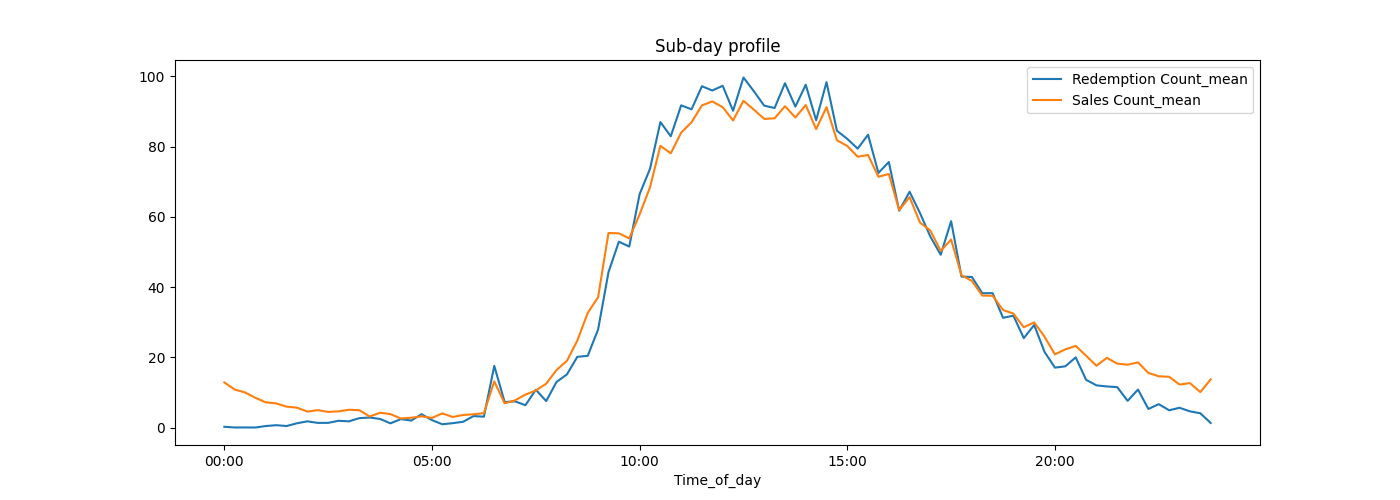

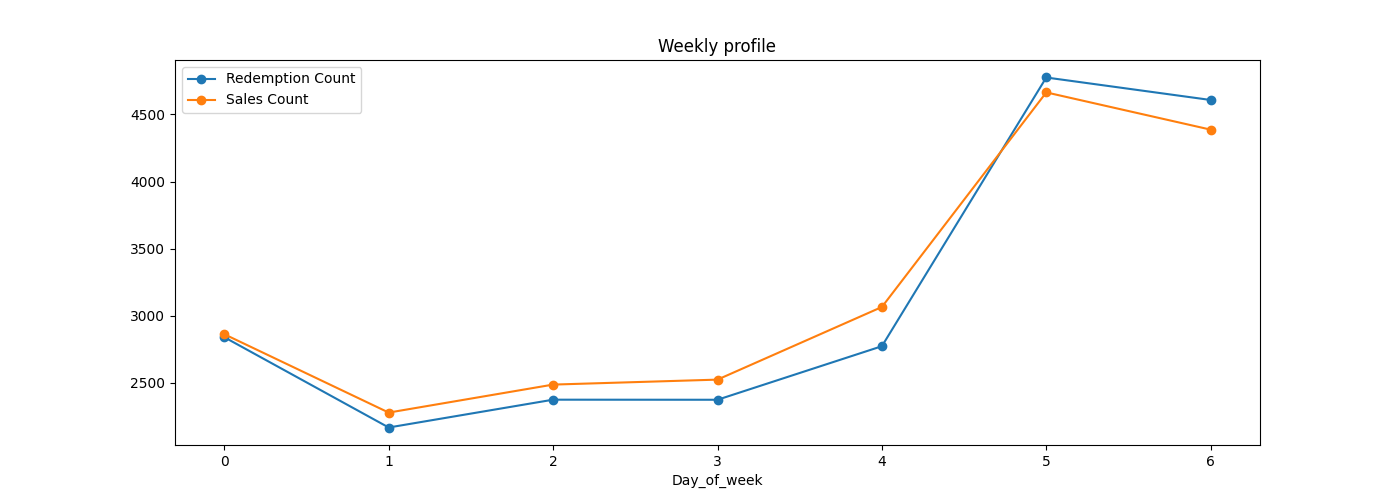

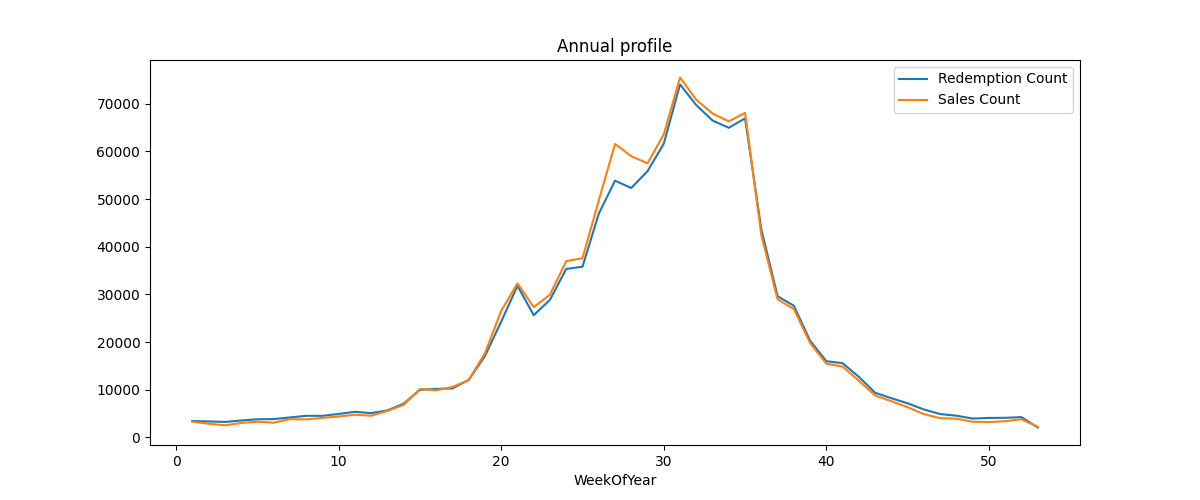

In [3]:
# Build analysis engine, cutting the last year off for testing / uncertainty
ae = run(
    Path("./data/Toronto Island Ferry Ticket Counts.csv"),
    split_date=None,
    split_fraction=None,
    split_test_timedelta=None,  #pd.Timedelta(365, "d"),
    verbose=True
)
ae.df_test = ae.df_train.copy()
ae.df_test = ae.df_test.reset_index()
ae.evaluate_uncertainty()
df2025 = ae.create_full_year_projection(2025)
ae.add_uncertainty_to_projection(df2025, "std")

In [4]:
def plot_projection_with_uncertainty(
    projection: pd.DataFrame, title: str, df_actual: pd.DataFrame = None):
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=False)

    # --- Full-range plot ---
    for col in ['Redemption Count', 'Sales Count']:
        ax1.plot(projection.index, projection[col], label=f'{col} (projection)')
        ax1.fill_between(
            projection.index,
            projection[f'{col} -1sigma'],
            projection[f'{col} +1sigma'],
            alpha=0.3,
            label=f'{col} ±1sigma'
        )

    # Add actuals to full-range plot if available
    if df_actual is not None:
        overlap = df_actual[df_actual.index.isin(projection.index)]
        for col in ['Redemption Count', 'Sales Count']:
            ax1.plot(overlap.index, overlap[col], label=f'{col} (actual)', linestyle='dotted', linewidth=1.5)

    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.legend()
    ax1.grid(True)

    # --- Zoomed-in plot ---
    zoom_start = pd.Timestamp('2025-06-01')
    zoom_end = pd.Timestamp('2025-06-11')
    zoom_df = projection[(projection.index >= zoom_start) & (projection.index <= zoom_end)]

    for col in ['Redemption Count', 'Sales Count']:
        ax2.plot(zoom_df.index, zoom_df[col], label=f'{col} (projection)')
        ax2.fill_between(
            zoom_df.index,
            zoom_df[f'{col} -1sigma'],
            zoom_df[f'{col} +1sigma'],
            alpha=0.3,
            label=f'{col} ±1sigma'
        )

    # Add actuals to zoomed-in plot if available
    if df_actual is not None:
        zoom_actual = df_actual[(df_actual.index >= zoom_start) & (df_actual.index <= zoom_end)]
        for col in ['Redemption Count', 'Sales Count']:
            ax2.plot(zoom_actual.index, zoom_actual[col], label=f'{col} (actual)', linestyle='dotted', linewidth=1.5)

    ax2.set_title(f"Zoomed In: {zoom_start.date()} to {zoom_end.date()}")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

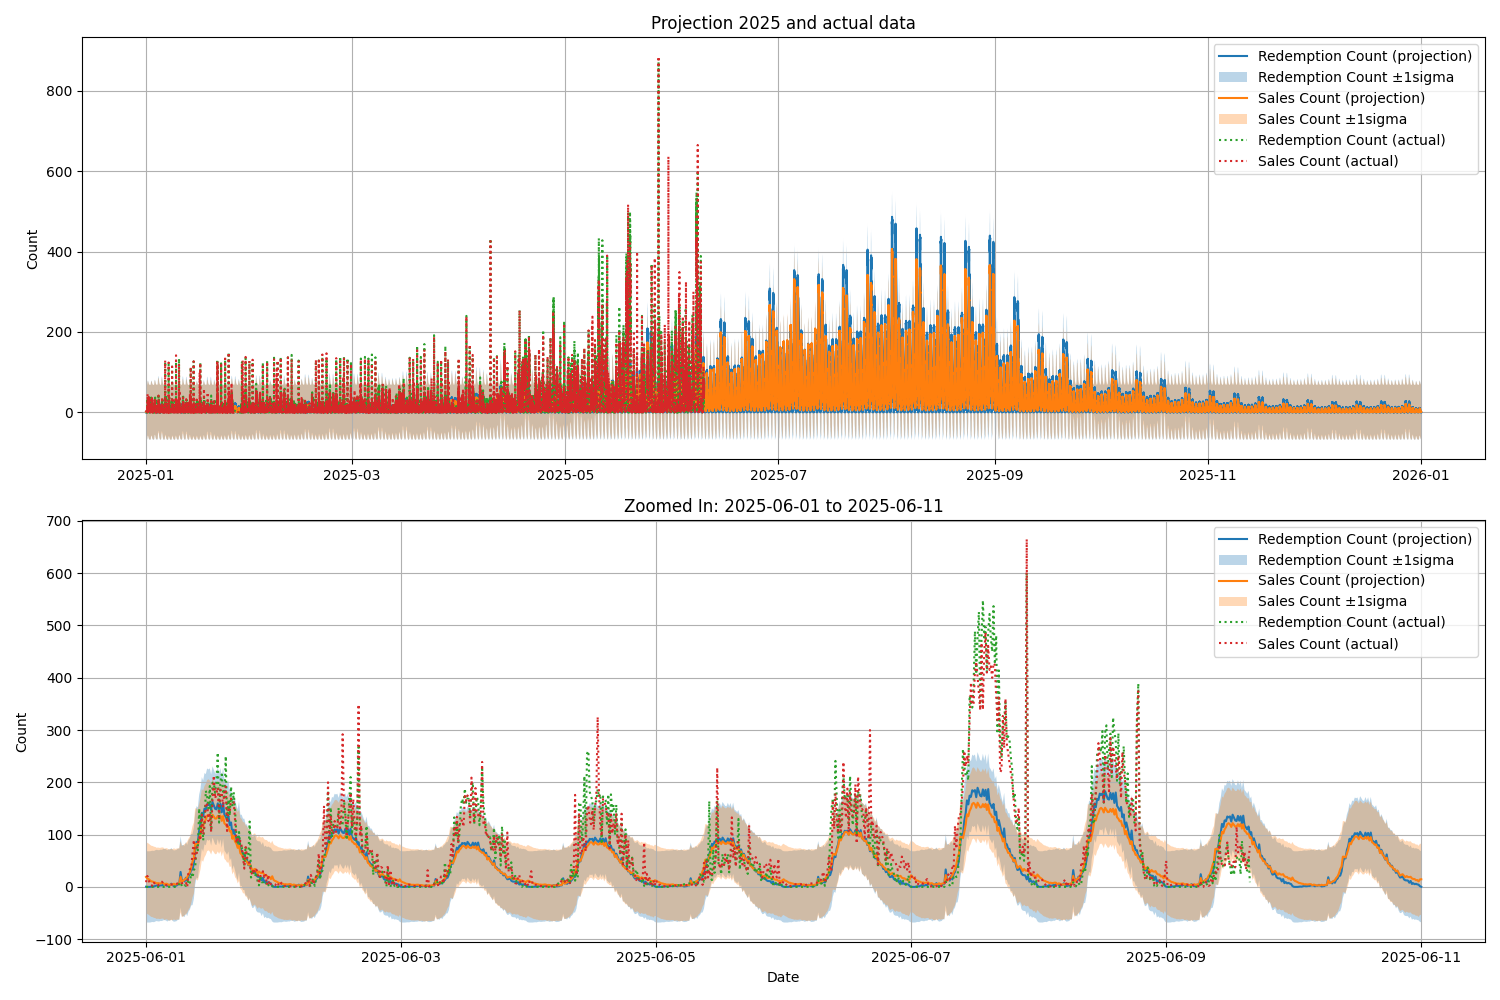

In [5]:
plot_projection_with_uncertainty(df2025, "Projection 2025 and actual data", ae.df_train)
